<a href="https://colab.research.google.com/github/Fayzak/CourseWorkGAN/blob/main/RememberUpScaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Super-Resolution**

https://github.com/krasserm/super-resolution

# Dataset

## data.py

Download dataset (data.py)

In [39]:
import os
import tensorflow as tf

from tensorflow.python.data.experimental import AUTOTUNE


class DIV2K:
    def __init__(self,
                 scale=2,
                 subset='train',
                 downgrade='bicubic',
                 images_dir='div2k/images',
                 caches_dir='div2k/caches'):

        self._ntire_2018 = True

        _scales = [2, 3, 4, 8]

        if scale in _scales:
            self.scale = scale
        else:
            raise ValueError(f'scale must be in ${_scales}')

        if subset == 'train':
            self.image_ids = range(1, 801)
        elif subset == 'valid':
            self.image_ids = range(801, 901)
        else:
            raise ValueError("subset must be 'train' or 'valid'")

        _downgrades_a = ['bicubic', 'unknown']
        _downgrades_b = ['mild', 'difficult']

        if scale == 8 and downgrade != 'bicubic':
            raise ValueError(f'scale 8 only allowed for bicubic downgrade')

        if downgrade in _downgrades_b and scale != 4:
            raise ValueError(f'{downgrade} downgrade requires scale 4')

        if downgrade == 'bicubic' and scale == 8:
            self.downgrade = 'x8'
        elif downgrade in _downgrades_b:
            self.downgrade = downgrade
        else:
            self.downgrade = downgrade
            self._ntire_2018 = False

        self.subset = subset
        self.images_dir = images_dir
        self.caches_dir = caches_dir

        os.makedirs(images_dir, exist_ok=True)
        os.makedirs(caches_dir, exist_ok=True)

    def __len__(self):
        return len(self.image_ids)

    def dataset(self, batch_size=16, repeat_count=None, random_transform=True):
        ds = tf.data.Dataset.zip((self.lr_dataset(), self.hr_dataset()))
        if random_transform:
            ds = ds.map(lambda lr, hr: random_crop(lr, hr, scale=self.scale), num_parallel_calls=AUTOTUNE)
            ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
            ds = ds.map(random_flip, num_parallel_calls=AUTOTUNE)
        ds = ds.batch(batch_size)
        ds = ds.repeat(repeat_count)
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

    def hr_dataset(self):
        if not os.path.exists(self._hr_images_dir()):
            download_archive(self._hr_images_archive(), self.images_dir, extract=True)

        ds = self._images_dataset(self._hr_image_files()).cache(self._hr_cache_file())

        if not os.path.exists(self._hr_cache_index()):
            self._populate_cache(ds, self._hr_cache_file())

        return ds

    def lr_dataset(self):
        if not os.path.exists(self._lr_images_dir()):
            download_archive(self._lr_images_archive(), self.images_dir, extract=True)

        ds = self._images_dataset(self._lr_image_files()).cache(self._lr_cache_file())

        if not os.path.exists(self._lr_cache_index()):
            self._populate_cache(ds, self._lr_cache_file())

        return ds

    def _hr_cache_file(self):
        return os.path.join(self.caches_dir, f'DIV2K_{self.subset}_HR.cache')

    def _lr_cache_file(self):
        return os.path.join(self.caches_dir, f'DIV2K_{self.subset}_LR_{self.downgrade}_X{self.scale}.cache')

    def _hr_cache_index(self):
        return f'{self._hr_cache_file()}.index'

    def _lr_cache_index(self):
        return f'{self._lr_cache_file()}.index'

    def _hr_image_files(self):
        images_dir = self._hr_images_dir()
        return [os.path.join(images_dir, f'{image_id:04}.png') for image_id in self.image_ids]

    def _lr_image_files(self):
        images_dir = self._lr_images_dir()
        return [os.path.join(images_dir, self._lr_image_file(image_id)) for image_id in self.image_ids]

    def _lr_image_file(self, image_id):
        if not self._ntire_2018 or self.scale == 8:
            return f'{image_id:04}x{self.scale}.png'
        else:
            return f'{image_id:04}x{self.scale}{self.downgrade[0]}.png'

    def _hr_images_dir(self):
        return os.path.join(self.images_dir, f'DIV2K_{self.subset}_HR')

    def _lr_images_dir(self):
        if self._ntire_2018:
            return os.path.join(self.images_dir, f'DIV2K_{self.subset}_LR_{self.downgrade}')
        else:
            return os.path.join(self.images_dir, f'DIV2K_{self.subset}_LR_{self.downgrade}', f'X{self.scale}')

    def _hr_images_archive(self):
        return f'DIV2K_{self.subset}_HR.zip'

    def _lr_images_archive(self):
        if self._ntire_2018:
            return f'DIV2K_{self.subset}_LR_{self.downgrade}.zip'
        else:
            return f'DIV2K_{self.subset}_LR_{self.downgrade}_X{self.scale}.zip'

    @staticmethod
    def _images_dataset(image_files):
        ds = tf.data.Dataset.from_tensor_slices(image_files)
        ds = ds.map(tf.io.read_file)
        ds = ds.map(lambda x: tf.image.decode_png(x, channels=3), num_parallel_calls=AUTOTUNE)
        return ds

    @staticmethod
    def _populate_cache(ds, cache_file):
        print(f'Caching decoded images in {cache_file} ...')
        for _ in ds: pass
        print(f'Cached decoded images in {cache_file}.')


# -----------------------------------------------------------
#  Transformations
# -----------------------------------------------------------


def random_crop(lr_img, hr_img, hr_crop_size=96, scale=2):
    lr_crop_size = hr_crop_size // scale
    lr_img_shape = tf.shape(lr_img)[:2]

    lr_w = tf.random.uniform(shape=(), maxval=lr_img_shape[1] - lr_crop_size + 1, dtype=tf.int32)
    lr_h = tf.random.uniform(shape=(), maxval=lr_img_shape[0] - lr_crop_size + 1, dtype=tf.int32)

    hr_w = lr_w * scale
    hr_h = lr_h * scale

    lr_img_cropped = lr_img[lr_h:lr_h + lr_crop_size, lr_w:lr_w + lr_crop_size]
    hr_img_cropped = hr_img[hr_h:hr_h + hr_crop_size, hr_w:hr_w + hr_crop_size]

    return lr_img_cropped, hr_img_cropped


def random_flip(lr_img, hr_img):
    rn = tf.random.uniform(shape=(), maxval=1)
    return tf.cond(rn < 0.5,
                   lambda: (lr_img, hr_img),
                   lambda: (tf.image.flip_left_right(lr_img),
                            tf.image.flip_left_right(hr_img)))


def random_rotate(lr_img, hr_img):
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    return tf.image.rot90(lr_img, rn), tf.image.rot90(hr_img, rn)


# -----------------------------------------------------------
#  IO
# -----------------------------------------------------------


def download_archive(file, target_dir, extract=True):
    source_url = f'http://data.vision.ee.ethz.ch/cvl/DIV2K/{file}'
    target_dir = os.path.abspath(target_dir)
    tf.keras.utils.get_file(file, source_url, cache_subdir=target_dir, extract=extract)
    os.remove(os.path.join(target_dir, file))

## Data Loader

In [40]:
train = DIV2K(scale=4, 
              downgrade='bicubic', 
              subset='train')

train_ds = train.dataset(batch_size=16, 
                         random_transform=True,
                         repeat_count=None)

246915072/246914039 [==============================] - 11s 0us/step
Caching decoded images in div2k/caches/DIV2K_train_LR_bicubic_X4.cache ...
Cached decoded images in div2k/caches/DIV2K_train_LR_bicubic_X4.cache.
3530604544/3530603713 [==============================] - 131s 0us/step
Caching decoded images in div2k/caches/DIV2K_train_HR.cache ...
Cached decoded images in div2k/caches/DIV2K_train_HR.cache.


In [41]:
valid_loader = DIV2K(scale=4,             
                     downgrade='bicubic', 
                     subset='valid')      
                             
valid_ds = valid_loader.dataset(batch_size=1,           
                                random_transform=False, 
                                repeat_count=1)         

31506432/31505881 [==============================] - 2s 0us/step
Caching decoded images in div2k/caches/DIV2K_valid_LR_bicubic_X4.cache ...
Cached decoded images in div2k/caches/DIV2K_valid_LR_bicubic_X4.cache.
448995328/448993893 [==============================] - 18s 0us/step
Caching decoded images in div2k/caches/DIV2K_valid_HR.cache ...
Cached decoded images in div2k/caches/DIV2K_valid_HR.cache.


# Models

## common.py


In [4]:
import numpy as np
import tensorflow as tf


DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255


def resolve_single(model, lr):
    return resolve(model, tf.expand_dims(lr, axis=0))[0]


def resolve(model, lr_batch):
    lr_batch = tf.cast(lr_batch, tf.float32)
    sr_batch = model(lr_batch)
    sr_batch = tf.clip_by_value(sr_batch, 0, 255)
    sr_batch = tf.round(sr_batch)
    sr_batch = tf.cast(sr_batch, tf.uint8)
    return sr_batch


def evaluate(model, dataset):
    psnr_values = []
    for lr, hr in dataset:
        sr = resolve(model, lr)
        psnr_value = psnr(hr, sr)[0]
        psnr_values.append(psnr_value)
    return tf.reduce_mean(psnr_values)


# ---------------------------------------
#  Normalization
# ---------------------------------------


def normalize(x, rgb_mean=DIV2K_RGB_MEAN):
    return (x - rgb_mean) / 127.5


def denormalize(x, rgb_mean=DIV2K_RGB_MEAN):
    return x * 127.5 + rgb_mean


def normalize_01(x):
    """Normalizes RGB images to [0, 1]."""
    return x / 255.0


def normalize_m11(x):
    """Normalizes RGB images to [-1, 1]."""
    return x / 127.5 - 1


def denormalize_m11(x):
    """Inverse of normalize_m11."""
    return (x + 1) * 127.5


# ---------------------------------------
#  Metrics
# ---------------------------------------


def psnr(x1, x2):
    return tf.image.psnr(x1, x2, max_val=255)


# ---------------------------------------
#  See https://arxiv.org/abs/1609.05158
# ---------------------------------------


def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)

## ESDR

In [44]:
from keras.layers import Add, Conv2D, Input, Lambda
from keras.models import Model


def edsr(scale, num_filters=64, num_res_blocks=8, res_block_scaling=None):
    x_in = Input(shape=(None, None, 3))
    x = Lambda(normalize)(x_in)

    x = b = Conv2D(num_filters, 3, padding='same')(x)
    for i in range(num_res_blocks):
        b = res_block(b, num_filters, res_block_scaling)
    b = Conv2D(num_filters, 3, padding='same')(b)
    x = Add()([x, b])

    x = upsample(x, scale, num_filters)
    x = Conv2D(3, 3, padding='same')(x)

    x = Lambda(denormalize)(x)
    return Model(x_in, x, name="edsr")


def res_block(x_in, filters, scaling):
    x = Conv2D(filters, 3, padding='same', activation='relu')(x_in)
    x = Conv2D(filters, 3, padding='same')(x)
    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add()([x_in, x])
    return x


def upsample(x, scale, num_filters):
    def upsample_1(x, factor, **kwargs):
        x = Conv2D(num_filters * (factor ** 2), 3, padding='same', **kwargs)(x)
        return Lambda(pixel_shuffle(scale=factor))(x)

    if scale == 2:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
    elif scale == 3:
        x = upsample_1(x, 3, name='conv2d_1_scale_3')
    elif scale == 4:
        x = upsample_1(x, 2, name='conv2d_1_scale_2')
        x = upsample_1(x, 2, name='conv2d_2_scale_2')

    return x

## WDSR

In [6]:
!pip install tensorflow-addons

     |████████████████████████████████| 686kB 6.1MB/s 


In [26]:
import tensorflow_addons as tfa


def wdsr_a(scale, num_filters=32, num_res_blocks=8, res_block_expansion=4, res_block_scaling=None):
    return wdsr(scale, num_filters, num_res_blocks, res_block_expansion, res_block_scaling, res_block_a)


def wdsr_b(scale, num_filters=32, num_res_blocks=8, res_block_expansion=6, res_block_scaling=None):
    return wdsr(scale, num_filters, num_res_blocks, res_block_expansion, res_block_scaling, res_block_b)


def wdsr(scale, num_filters, num_res_blocks, res_block_expansion, res_block_scaling, res_block):
    x_in = Input(shape=(None, None, 3))
    x = Lambda(normalize)(x_in)

    # main branch
    m = conv2d_weightnorm(num_filters, 3, padding='same')(x)
    for i in range(num_res_blocks):
        m = res_block(m, num_filters, res_block_expansion, kernel_size=3, scaling=res_block_scaling)
    m = conv2d_weightnorm(3 * scale ** 2, 3, padding='same', name=f'conv2d_main_scale_{scale}')(m)
    m = Lambda(pixel_shuffle(scale))(m)

    # skip branch
    s = conv2d_weightnorm(3 * scale ** 2, 5, padding='same', name=f'conv2d_skip_scale_{scale}')(x)
    s = Lambda(pixel_shuffle(scale))(s)

    x = Add()([m, s])
    x = Lambda(denormalize)(x)

    return Model(x_in, x, name="wdsr")


def res_block_a(x_in, num_filters, expansion, kernel_size, scaling):
    x = conv2d_weightnorm(num_filters * expansion, kernel_size, padding='same', activation='relu')(x_in)
    x = conv2d_weightnorm(num_filters, kernel_size, padding='same')(x)
    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add()([x_in, x])
    return x


def res_block_b(x_in, num_filters, expansion, kernel_size, scaling):
    linear = 0.8
    x = conv2d_weightnorm(num_filters * expansion, 1, padding='same', activation='relu')(x_in)
    x = conv2d_weightnorm(int(num_filters * linear), 1, padding='same')(x)
    x = conv2d_weightnorm(num_filters, kernel_size, padding='same')(x)
    if scaling:
        x = Lambda(lambda t: t * scaling)(x)
    x = Add()([x_in, x])
    return x


def conv2d_weightnorm(filters, kernel_size, padding='same', activation=None, **kwargs):
    return tfa.layers.WeightNormalization(Conv2D(filters, kernel_size, padding=padding, activation=activation, **kwargs), data_init=False)

## SRGAN

In [52]:
from keras.layers import Add, BatchNormalization, Conv2D, Dense, Flatten, Input, LeakyReLU, PReLU, Lambda
from keras.models import Model
from keras.applications.vgg19 import VGG19

LR_SIZE = 24
HR_SIZE = 96


def upsample(x_in, num_filters):
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x_in)
    x = Lambda(pixel_shuffle(scale=2))(x)
    return PReLU(shared_axes=[1, 2])(x)


def res_block(x_in, num_filters, momentum=0.8):
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x_in)
    x = BatchNormalization(momentum=momentum)(x)
    x = PReLU(shared_axes=[1, 2])(x)
    x = Conv2D(num_filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization(momentum=momentum)(x)
    x = Add()([x_in, x])
    return x


def sr_resnet(num_filters=64, num_res_blocks=16):
    x_in = Input(shape=(None, None, 3))
    x = Lambda(normalize_01)(x_in)

    x = Conv2D(num_filters, kernel_size=9, padding='same')(x)
    x = x_1 = PReLU(shared_axes=[1, 2])(x)

    for _ in range(num_res_blocks):
        x = res_block(x, num_filters)

    x = Conv2D(num_filters, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x_1, x])

    x = upsample(x, num_filters * 4)
    x = upsample(x, num_filters * 4)

    x = Conv2D(3, kernel_size=9, padding='same', activation='tanh')(x)
    x = Lambda(denormalize_m11)(x)

    return Model(x_in, x)


generator = sr_resnet


def discriminator_block(x_in, num_filters, strides=1, batchnorm=True, momentum=0.8):
    x = Conv2D(num_filters, kernel_size=3, strides=strides, padding='same')(x_in)
    if batchnorm:
        x = BatchNormalization(momentum=momentum)(x)
    return LeakyReLU(alpha=0.2)(x)


def discriminator(num_filters=64):
    x_in = Input(shape=(HR_SIZE, HR_SIZE, 3))
    x = Lambda(normalize_m11)(x_in)

    x = discriminator_block(x, num_filters, batchnorm=False)
    x = discriminator_block(x, num_filters, strides=2)

    x = discriminator_block(x, num_filters * 2)
    x = discriminator_block(x, num_filters * 2, strides=2)

    x = discriminator_block(x, num_filters * 4)
    x = discriminator_block(x, num_filters * 4, strides=2)

    x = discriminator_block(x, num_filters * 8)
    x = discriminator_block(x, num_filters * 8, strides=2)

    x = Flatten()(x)

    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1, activation='sigmoid')(x)

    return Model(x_in, x)


def vgg_22():
    return _vgg(5)


def vgg_54():
    return _vgg(20)


def _vgg(output_layer):
    vgg = VGG19(input_shape=(None, None, 3), include_top=False)
    return Model(vgg.input, vgg.layers[output_layer].output)

# Next

## utils.py

In [48]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

def load_image(path):
  return np.array(Image.open(path))

def plot_sample(lr, sr):
  plt.figure(figsize=(20, 10))

  images = [lr, sr]
  titles = ['LR', f'SR (x{sr.shape[0] // lr.shape[0]})']

  for i, (img, title) in enumerate(zip(images, titles)):
    plt.subplot(1, 2, i+1)
    plt.imshow(img)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])

# Train (if you have PRO subscription)

In [ ]:
import time
import tensorflow as tf

from model import evaluate
from model import srgan

from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay


class Trainer:
    def __init__(self,
                 model,
                 loss,
                 learning_rate,
                 checkpoint_dir='./ckpt/edsr'):

        self.now = None
        self.loss = loss
        self.checkpoint = tf.train.Checkpoint(step=tf.Variable(0),
                                              psnr=tf.Variable(-1.0),
                                              optimizer=Adam(learning_rate),
                                              model=model)
        self.checkpoint_manager = tf.train.CheckpointManager(checkpoint=self.checkpoint,
                                                             directory=checkpoint_dir,
                                                             max_to_keep=3)

        self.restore()

    @property
    def model(self):
        return self.checkpoint.model

    def train(self, train_dataset, valid_dataset, steps, evaluate_every=1000, save_best_only=False):
        loss_mean = Mean()

        ckpt_mgr = self.checkpoint_manager
        ckpt = self.checkpoint

        self.now = time.perf_counter()

        for lr, hr in train_dataset.take(steps - ckpt.step.numpy()):
            ckpt.step.assign_add(1)
            step = ckpt.step.numpy()

            loss = self.train_step(lr, hr)
            loss_mean(loss)

            if step % evaluate_every == 0:
                loss_value = loss_mean.result()
                loss_mean.reset_states()

                # Compute PSNR on validation dataset
                psnr_value = self.evaluate(valid_dataset)

                duration = time.perf_counter() - self.now
                print(f'{step}/{steps}: loss = {loss_value.numpy():.3f}, PSNR = {psnr_value.numpy():3f} ({duration:.2f}s)')

                if save_best_only and psnr_value <= ckpt.psnr:
                    self.now = time.perf_counter()
                    # skip saving checkpoint, no PSNR improvement
                    continue

                ckpt.psnr = psnr_value
                ckpt_mgr.save()

                self.now = time.perf_counter()

    @tf.function
    def train_step(self, lr, hr):
        with tf.GradientTape() as tape:
            lr = tf.cast(lr, tf.float32)
            hr = tf.cast(hr, tf.float32)

            sr = self.checkpoint.model(lr, training=True)
            loss_value = self.loss(hr, sr)

        gradients = tape.gradient(loss_value, self.checkpoint.model.trainable_variables)
        self.checkpoint.optimizer.apply_gradients(zip(gradients, self.checkpoint.model.trainable_variables))

        return loss_value

    def evaluate(self, dataset):
        return evaluate(self.checkpoint.model, dataset)

    def restore(self):
        if self.checkpoint_manager.latest_checkpoint:
            self.checkpoint.restore(self.checkpoint_manager.latest_checkpoint)
            print(f'Model restored from checkpoint at step {self.checkpoint.step.numpy()}.')


class EdsrTrainer(Trainer):
    def __init__(self,
                 model,
                 checkpoint_dir,
                 learning_rate=PiecewiseConstantDecay(boundaries=[200000], values=[1e-4, 5e-5])):
        super().__init__(model, loss=MeanAbsoluteError(), learning_rate=learning_rate, checkpoint_dir=checkpoint_dir)

    def train(self, train_dataset, valid_dataset, steps=300000, evaluate_every=1000, save_best_only=True):
        super().train(train_dataset, valid_dataset, steps, evaluate_every, save_best_only)


class WdsrTrainer(Trainer):
    def __init__(self,
                 model,
                 checkpoint_dir,
                 learning_rate=PiecewiseConstantDecay(boundaries=[200000], values=[1e-3, 5e-4])):
        super().__init__(model, loss=MeanAbsoluteError(), learning_rate=learning_rate, checkpoint_dir=checkpoint_dir)

    def train(self, train_dataset, valid_dataset, steps=300000, evaluate_every=1000, save_best_only=True):
        super().train(train_dataset, valid_dataset, steps, evaluate_every, save_best_only)


class SrganGeneratorTrainer(Trainer):
    def __init__(self,
                 model,
                 checkpoint_dir,
                 learning_rate=1e-4):
        super().__init__(model, loss=MeanSquaredError(), learning_rate=learning_rate, checkpoint_dir=checkpoint_dir)

    def train(self, train_dataset, valid_dataset, steps=1000000, evaluate_every=1000, save_best_only=True):
        super().train(train_dataset, valid_dataset, steps, evaluate_every, save_best_only)


class SrganTrainer:
    #
    # TODO: model and optimizer checkpoints
    #
    def __init__(self,
                 generator,
                 discriminator,
                 content_loss='VGG54',
                 learning_rate=PiecewiseConstantDecay(boundaries=[100000], values=[1e-4, 1e-5])):

        if content_loss == 'VGG22':
            self.vgg = srgan.vgg_22()
        elif content_loss == 'VGG54':
            self.vgg = srgan.vgg_54()
        else:
            raise ValueError("content_loss must be either 'VGG22' or 'VGG54'")

        self.content_loss = content_loss
        self.generator = generator
        self.discriminator = discriminator
        self.generator_optimizer = Adam(learning_rate=learning_rate)
        self.discriminator_optimizer = Adam(learning_rate=learning_rate)

        self.binary_cross_entropy = BinaryCrossentropy(from_logits=False)
        self.mean_squared_error = MeanSquaredError()

    def train(self, train_dataset, steps=200000):
        pls_metric = Mean()
        dls_metric = Mean()
        step = 0

        for lr, hr in train_dataset.take(steps):
            step += 1

            pl, dl = self.train_step(lr, hr)
            pls_metric(pl)
            dls_metric(dl)

            if step % 50 == 0:
                print(f'{step}/{steps}, perceptual loss = {pls_metric.result():.4f}, discriminator loss = {dls_metric.result():.4f}')
                pls_metric.reset_states()
                dls_metric.reset_states()

    @tf.function
    def train_step(self, lr, hr):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            lr = tf.cast(lr, tf.float32)
            hr = tf.cast(hr, tf.float32)

            sr = self.generator(lr, training=True)

            hr_output = self.discriminator(hr, training=True)
            sr_output = self.discriminator(sr, training=True)

            con_loss = self._content_loss(hr, sr)
            gen_loss = self._generator_loss(sr_output)
            perc_loss = con_loss + 0.001 * gen_loss
            disc_loss = self._discriminator_loss(hr_output, sr_output)

        gradients_of_generator = gen_tape.gradient(perc_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return perc_loss, disc_loss

    @tf.function
    def _content_loss(self, hr, sr):
        sr = preprocess_input(sr)
        hr = preprocess_input(hr)
        sr_features = self.vgg(sr) / 12.75
        hr_features = self.vgg(hr) / 12.75
        return self.mean_squared_error(hr_features, sr_features)

    def _generator_loss(self, sr_out):
        return self.binary_cross_entropy(tf.ones_like(sr_out), sr_out)

    def _discriminator_loss(self, hr_out, sr_out):
        hr_loss = self.binary_cross_entropy(tf.ones_like(hr_out), hr_out)
        sr_loss = self.binary_cross_entropy(tf.zeros_like(sr_out), sr_out)
        return hr_loss + sr_loss

# Test 3 Models

In [17]:
!unzip weights.zip

Archive:  weights.zip
   creating: weights/edsr-16-x4/
  inflating: weights/edsr-16-x4/weights.h5  
   creating: weights/srgan/
  inflating: weights/srgan/gan_discriminator.h5  
  inflating: weights/srgan/gan_generator.h5  
  inflating: weights/srgan/pre_generator.h5  
   creating: weights/wdsr-b-32-x4/
  inflating: weights/wdsr-b-32-x4/weights.h5  


In [42]:
!unzip demo.zip

Archive:  demo.zip
  inflating: demo/0829x4-crop.png    
  inflating: demo/0851x4-crop.png    
  inflating: demo/0869x4-crop.png    


## EDSR

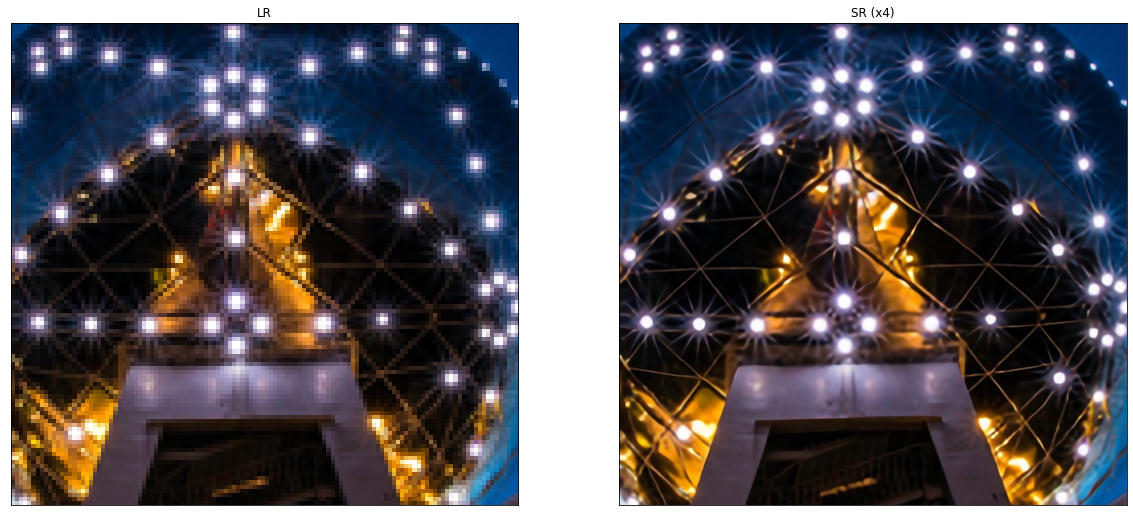

In [49]:
model = esdr(scale=4, num_res_blocks=16)
model.load_weights('weights/edsr-16-x4/weights.h5')

lr = load_image('demo/0851x4-crop.png')
sr = resolve_single(model, lr)

plot_sample(lr, sr)

## WDSR

In [ ]:
model = wdsr_b(scale=4, num_res_blocks=32)
model.load_weights('weights/wdsr-b-32-x4/weights.h5')

lr = load_image('demo/0829x4-crop.png')
sr = resolve_single(model, lr)

plot_sample(lr, sr)

## SRGAN

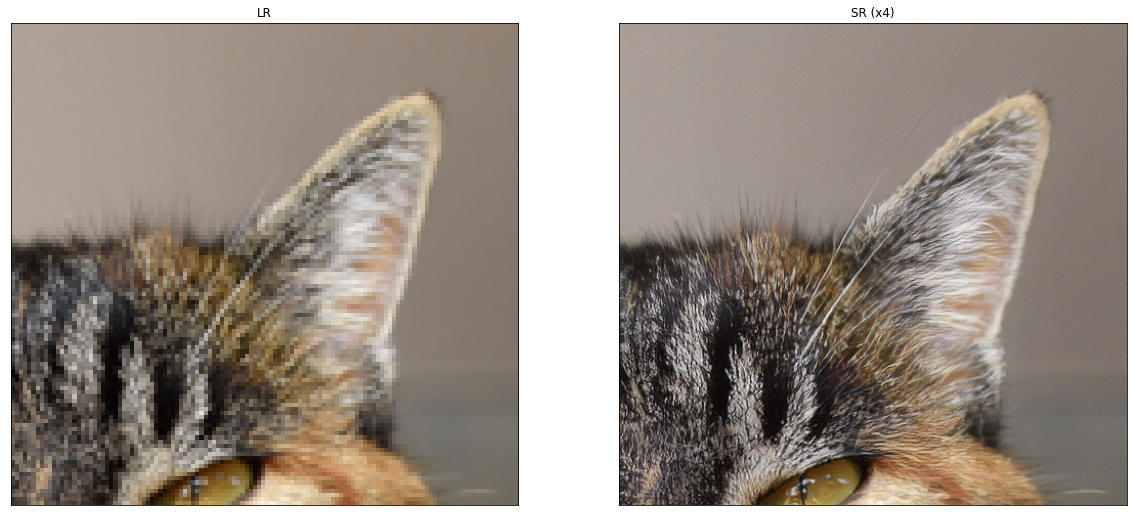

In [53]:
model = generator()
model.load_weights('weights/srgan/gan_generator.h5')

lr = load_image('demo/0869x4-crop.png')
sr = resolve_single(model, lr)

plot_sample(lr, sr)